# Handwritten Digits

**Goal:** 

Apply PCA-decomposition to do some exploratory data analysis. More concretely, we look for clusters in a set of handwritten digits.


`scikit-Learn` comes with a number of data sets. Here we take a look at the digits data set. This data set consists of images of handwritten digits, each represent by $(8\times 8)$ matrix of greyscale values, or equivalently a 64-dimensional vector. In addition, there are labels for the images given the actual digit. The data set is neatly structured in form of a dictionary:

In [17]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
digits = load_digits()
# The images are given by `digits.data' and the corresponding labels are given in `digits.target`:
X_digits, y_digits = digits.data, digits.target
print(digits.keys())

import matplotlib
%matplotlib inline

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])


In [18]:
print(digits.DESCR)


.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each bloc

Let's take a look at the data:

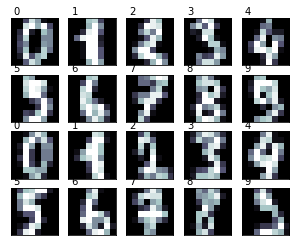

In [20]:
n_row, n_col = 4, 5

def print_digits(images, y, max_n=10):
    fig = plt.figure(figsize=(n_col, n_row))
    i=0
    while i < max_n and i < images.shape[0]:
        p = fig.add_subplot(n_row, n_col, i + 1, xticks=[], yticks=[])
        p.imshow(images[i], cmap=plt.cm.bone, interpolation='nearest')
        # Label the image with the target value:
        p.text(0, -1, str(y[i]))
        i = i + 1
#     fig.show()

print_digits(digits.images, digits.target, max_n=20)

Let's perform PCA with 10 components. 

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_digits)
for i, explained_variance_ratio in enumerate(pca.explained_variance_ratio_):
    print("Variance explained by the " + str(i + 1) + "-th principal component:\t" + str(explained_variance_ratio))

Variance explained by the 1-th principal component:	0.14890593583542122
Variance explained by the 2-th principal component:	0.1361877123869739
Variance explained by the 3-th principal component:	0.11794593763342774
Variance explained by the 4-th principal component:	0.08409979419117893
Variance explained by the 5-th principal component:	0.057824145782229955
Variance explained by the 6-th principal component:	0.04916909763673025
Variance explained by the 7-th principal component:	0.043159845756920535
Variance explained by the 8-th principal component:	0.036613598707700305
Variance explained by the 9-th principal component:	0.0335322002875408
Variance explained by the 10-th principal component:	0.030787881717330157


### 1. Using PCA for image compression 

We can use the `transform` and `inverse_transform` methods to go back and forth between dimensions.

In [22]:
X_reduced = pca.transform(X_digits) # Transform all the data into the PC space

In [23]:
X_recovered = pca.inverse_transform(X_reduced) # Bring the encoded data to the original space

In [24]:
images_recovered = X_recovered.reshape(X_recovered.shape[0],8,8) # Reshape a bit (to plot it)

Reconstructed data


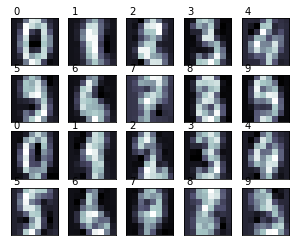

In [25]:
print_digits(images_recovered, digits.target, max_n=20)
print("Reconstructed data")

((1797, 10), (1797, 64))

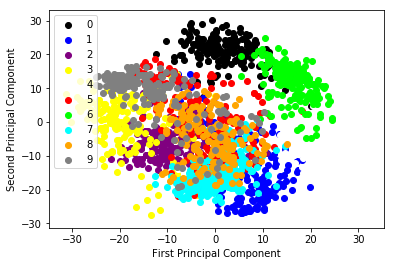

In [26]:
def plot_pca_scatter():
    colors = ['black', 'blue', 'purple', 'yellow', 'white', 'red', 'lime', 'cyan', 'orange', 'gray']
    for i in range(len(colors)):
        px = X_pca[:, 0][y_digits == i]
        py = X_pca[:, 1][y_digits == i]
        plt.scatter(px, py, c=colors[i])
        plt.legend(digits.target_names)
        plt.xlabel('First Principal Component')
        plt.ylabel('Second Principal Component')
        
n_components=2
plot_pca_scatter()
X_pca.shape, X_digits.shape

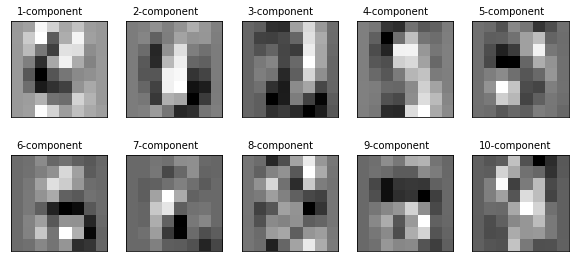

In [31]:
def print_pca_components(images, n_col, n_row):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    for i, comp in enumerate(images):
        if i <= n_col * n_row:
            plt.subplot(n_row, n_col, i + 1)
            plt.imshow(comp.reshape((8, 8)), interpolation='nearest', cmap='binary')
            plt.text(0, -1, str(i + 1) + '-component')
            plt.xticks(())
            plt.yticks(())
        else:
            break
        
print_pca_components(pca.components_, 5, 2)

We can measure how good this reconstruction was using the mean squared error: 

In [28]:
from sklearn.metrics import mean_squared_error

In [29]:
mean_squared_error(X_digits, X_recovered)

4.9142994877882105

In [30]:
np.sum(pca.explained_variance_ratio_)

0.7382261499354538

So at around 74% of variance explained, we get about 5 errors in the reconstruction. Not bad :)

#### Your task:

- How does the reconstruction error depend on the number of components? 
- Is there any class that is particularly harder to reconstruct? **Hint:** `mean_squared_error(X_digits[0], X_recovered[0])` gives the reconstruction error and `digits.target[0]` the class of the first element.

### 2. Using dimensionality reduction to improve model performance

A common application is to use first PCA to find a lower dimensional representation and then train a model there. This can hopefully help us improve the performance of the model.

In our example, we can train a model using `X_reduced` as our data and `digits.target` as our, well, target.

#### Your task: 

- How does a logistic regression model trained in the original data (no dimensionality reduction) compare to a logistic regression model trained in a reduced version? How does it change with the number of components. Plot the number of components against model error. 
- How about a non-linear embedding? Does this help to improve the model in this case? You can use `LLE` (recall from the lecture) with the following code:

In [16]:
from sklearn.manifold import LocallyLinearEmbedding

In [17]:
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=5)
X_reduced = lle.fit_transform(X_digits)
